# Models training
In this notebook we train and analyze multiple models, compare them and tune them to get the best results. We will work with a small subset due to low hardware availability.

## 0.1 Load variable
This notebook is a direct continuation of data_preprocessing.ipynb. We start by loading the necessary libraries variables from that.

In [178]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from collections import Counter
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


with open('landmarks_subset_proccessed.pkl', 'rb') as file:
    subset_landmarks = pickle.load(file)

data_info = pd.read_csv('video_labels.csv',dtype={'video_id': object})
subset_words = ['tall', 'man', 'red', 'shirt', 'play', 'basketball', 'cold', 'pizza', 'top', 'cheese', 'taste',
                'delicious', 'lazy', 'afternoon', 'dark', 'room', 'small', 'lamp', 'empty',
                'big', 'dog', 'walk', 'beautiful', 'every', 'morning', 'short',
                'woman', 'wear', 'dress', 'have', 'beautiful', 'daughter']


POSE = np.hstack((np.ones(33), np.zeros(21+21+468))) == 1
LH = np.hstack((np.zeros(33), np.ones(21), np.zeros(21+468))) == 1
RH = np.hstack((np.zeros(33+21), np.ones(21), np.zeros(468))) == 1
FACE = np.hstack((np.zeros(33+21+21), np.ones(468))) == 1
videos_per_word = Counter(data_info.loc[data_info.word.isin(subset_words),'word'])

In [2]:
train_signer_ids = [118, 31, 59, 11, 115, 94, 6, 21, 10, 38, 56, 41, 4, 45, 32, 46, 13,
                    42, 39, 17, 89, 60, 35, 15, 3, 92, 93, 34, 107, 28, 99, 37, 8, 97,
                    70, 19, 91, 106, 63, 29, 26, 117, 66, 119, 50, 103, 120, 95, 78, 27,
                    108, 57, 53, 75, 104, 43, 40, 77, 1, 33, 22, 105, 48, 73, 23]
val_signer_ids = [2, 52, 12, 98, 88]
test_signer_ids = [59, 115, 90, 4, 116, 100, 101, 102, 96, 90]

num_of_words = data_info[data_info["word"].isin(subset_words)]["word"].nunique()
subset_data = data_info[data_info["word"].isin(subset_words)]
subset_train_data = subset_data[subset_data["signer_id"].isin(train_signer_ids)]
subset_test_data = subset_data[subset_data["signer_id"].isin(val_signer_ids)]
subset_validation_data = subset_data[subset_data["signer_id"].isin(test_signer_ids)]

print(f"subset train data count: {len(subset_train_data)}")
print(f"subset test data count: {len(subset_test_data)}")
print(f"subset validation data count: {len(subset_validation_data)}")
print(f"num of words: {num_of_words}")

subset train data count: 202
subset test data count: 37
subset validation data count: 32
num of words: 31


# 1.0 Unsupervised
We first try and distinguish the words without letting the model know the labels.

# 1.1 Dynamic Time Wrapping and KMeans (DTW)
Dynamic Time Wrapping can detect similar motions but its computation is slow, let's take videos of two words only, without the face (which has the majority of landmarks) and check whether it is a good approach.

We start with a sainity check for DTW. Just a few sample to keep computations reasonably quick.

In [43]:
SKIP_FRAMES = 3 # Take every 3rd frame to speed training up. It is an hyperparameter as well

words = ["play","basketball","morning","tall","dress","beautiful"]
words = ["short", "tall", "woman", "man","small", "big", "morning", "afternoon", ]
for word in words:
    print(word, videos_per_word[word])

dtw_landmarks = {}
for word in words:
    videos = data_info.loc[data_info.word==word,'video_id']
    # Exclude augmented videos for now
    for vid in videos[:2]:
        dtw_landmarks[vid] = subset_landmarks[vid][::SKIP_FRAMES,POSE+LH+RH,:]
len(dtw_landmarks)

short 13
tall 13
woman 11
man 12
small 8
big 9
morning 6
afternoon 7


16

/Users/oren/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/oren/anaconda3/envs/tf/lib/python3.8/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


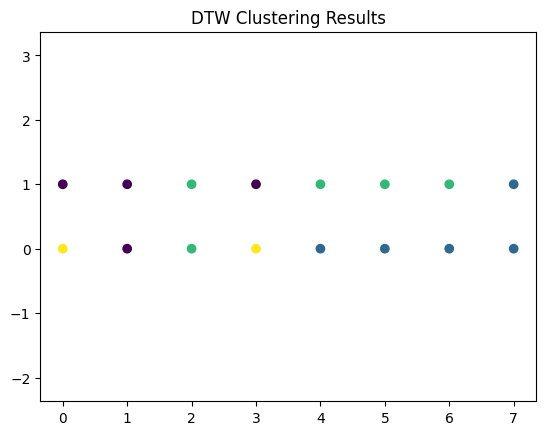

['short', 'tall', 'woman', 'man', 'small', 'big', 'morning', 'afternoon']


In [3]:
# Me: write me a python code to cluster mediapipe video landmarks using DTW
# ChatGPT 3.5 answers:

# Function to compute DTW distance between two sequences
def dtw_distance(seq1, seq2):
    distance, path = fastdtw(seq1, seq2)
    return distance

# Function to perform clustering using DTW
def dtw_cluster(video_landmarks, num_clusters):
    # Flatten the video landmarks into sequences
    sequences = [frame.flatten() for frame in video_landmarks]

    # Compute pairwise DTW distances
    num_frames = len(video_landmarks)
    distances = np.zeros((num_frames, num_frames))
    for i in range(num_frames):
        for j in range(i + 1, num_frames):
            distances[i, j] = dtw_distance(sequences[i], sequences[j])
            distances[j, i] = distances[i, j]

    # Perform KMeans clustering based on DTW distances
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(distances)

    return labels

# Example usage
# Assuming 'video_landmarks' is a list of 2D arrays representing landmarks for each frame
# You can adjust 'num_clusters' based on your requirements
num_clusters = 4#len(words)
cluster_labels = dtw_cluster(dtw_landmarks.values(), num_clusters)

# Visualize the clustering results
x = np.array([i for i in range(len(dtw_landmarks))])%int(len(dtw_landmarks)/2)
y = [0] * int(len(dtw_landmarks)/2) + [1] * int(len(dtw_landmarks)/2)

#plt.scatter(range(len(dtw_landmarks)), [0] * len(dtw_landmarks), c=cluster_labels, cmap='viridis')
plt.scatter(x, y, c=cluster_labels, cmap='viridis')
plt.title('DTW Clustering Results')
plt.axis('equal')

plt.show()
print(words)

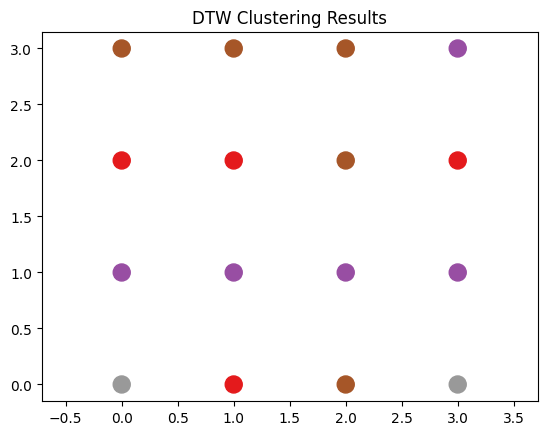

In [4]:
# Visualize the clustering results
x = np.array([i for i in range(len(dtw_landmarks))])%int(len(dtw_landmarks)/4)
y = [0] * int(len(dtw_landmarks)/4) + [1] * int(len(dtw_landmarks)/4) +[2] * int(len(dtw_landmarks)/4) + [3] * int(len(dtw_landmarks)/4)

#plt.scatter(range(len(dtw_landmarks)), [0] * len(dtw_landmarks), c=cluster_labels, cmap='viridis')
plt.scatter(x, y, c=cluster_labels, cmap='Set1', marker='o', s=150, alpha=1)
plt.title('DTW Clustering Results')
plt.axis('equal')
plt.show()

## 3.2 LSTM

<hr style="color: red">

ChatGPT code tryout

List of hyperparameters:
- **Frame rate** it alsmost certain that the accuracy won't change much between taking all frames and taking every other frame, but what is the lowest frame rate we can take without impacting the results too much?
- **Dimensions** Check wether 3D is significanly more sufficient than 2D
- **Face landmarks** Do the face landmarks contribute much? If yes, how many of them should we take?


In [179]:
PICKED_FRAMES = 24 # min([len(video) for video in landmarks.values()])
DIMENSTIONS = 3

In [180]:
def pick_frames(video,num_frames):
    ''' Take a subset of the frames, evenly spread over the whole video'''
    step_size = len(video) // num_frames
    video_shorter = video[::step_size][:num_frames]
    return video_shorter

In [181]:
words = subset_words

lstm_landmarks = {}
for word in words:
    videos = data_info.loc[data_info.word==word,'video_id']
    for vid in videos:
        lstm_landmarks[vid] = pick_frames(subset_landmarks[vid][:,POSE+LH+RH,:DIMENSTIONS].copy(),PICKED_FRAMES)
print(f'{len(lstm_landmarks)} videos in in total for {len(words)} words')

274 videos in in total for 32 words


In [182]:
for video_id, video in lstm_landmarks.items():
    sequences = np.array([frame.flatten() for frame in video])
    lstm_landmarks[video_id] = sequences

train_ids = list(data_info.loc[data_info.split=='train','video_id'])
validation_ids = list(data_info.loc[data_info.split=='val','video_id'])
test_ids = list(data_info.loc[data_info.split=='test','video_id'])


X_train = np.array([video for id, video in lstm_landmarks.items() if id in train_ids])
y_train = [data_info.loc[data_info.video_id==id,'word'].item() for id in lstm_landmarks.keys() if id in train_ids]

X_val = np.array([video for id, video in lstm_landmarks.items() if id in validation_ids])
y_val = [data_info.loc[data_info.video_id==id,'word'].item() for id in lstm_landmarks.keys() if id in validation_ids]

X_test = np.array([video for id, video in lstm_landmarks.items() if id in test_ids])
y_test = [data_info.loc[data_info.video_id==id,'word'].item() for id in lstm_landmarks.keys() if id in test_ids]

# Suffle the train set
num_instances = X_train.shape[0]
shuffled_indices = np.arange(num_instances)
np.random.shuffle(shuffled_indices)
X_train = X_train[shuffled_indices]
y_train = np.array(y_train)[shuffled_indices]

In [189]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

index_to_word = {word: i for i, word in enumerate(words)}
y_train_categorical = to_categorical([index_to_word[word] for word in y_train], num_classes=len(words))

input_shape = (lstm_landmarks[list(lstm_landmarks.keys())[0]].shape)  #Hopefully we can do variable number of frames later
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=input_shape))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(words), activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(X_train, y_train_categorical, epochs=100, batch_size=8)


Epoch 1/100
25/25 [==============================] - 5s 33ms/step - loss: 3.4698 - categorical_accuracy: 0.0258
Epoch 2/100
25/25 [==============================] - 1s 27ms/step - loss: 3.4135 - categorical_accuracy: 0.0464
Epoch 3/100
25/25 [==============================] - 1s 28ms/step - loss: 3.3938 - categorical_accuracy: 0.0979
Epoch 4/100
25/25 [==============================] - 0s 20ms/step - loss: 3.3929 - categorical_accuracy: 0.0979
Epoch 5/100
25/25 [==============================] - 0s 19ms/step - loss: 3.2805 - categorical_accuracy: 0.0928
Epoch 6/100
25/25 [==============================] - 0s 18ms/step - loss: 3.1690 - categorical_accuracy: 0.0670
Epoch 7/100
25/25 [==============================] - 0s 19ms/step - loss: 3.0576 - categorical_accuracy: 0.0670
Epoch 8/100
25/25 [==============================] - 0s 20ms/step - loss: 2.9762 - categorical_accuracy: 0.0928
Epoch 9/100
25/25 [==============================] - 1s 20ms/step - loss: 2.9145 - categorical_accuracy:

In [190]:
for i,j in enumerate(model.predict(X_val).argmax(axis=1)):
    if y_val[i] == words[j]:
        print("real:",y_val[i],"| output:", words[j])

2/2 [==============================] - 0s 12ms/step
real: tall | output: tall
real: basketball | output: basketball
real: lazy | output: lazy
real: big | output: big
real: big | output: big
real: beautiful | output: beautiful
real: woman | output: woman
real: daughter | output: daughter
